# 3_cross_validation_on_classification.ipynb

## Data import and test

In [106]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.model_selection import train_test_split, KFold, LeaveOneOut, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, zero_one_loss
from tqdm.auto import tqdm
import scipy.stats as st
from sklearn.metrics import matthews_corrcoef

# Auxiliary Functions

In [107]:
def get_fold_data(X, y, train_idx, val_idx):
    X_train = X.iloc[train_idx]
    X_val   = X.iloc[val_idx]
    y_train = y.iloc[train_idx]
    y_val   = y.iloc[val_idx]
    return X_train, X_val, y_train, y_val


def get_fold_data_normalized(X, y, train_idx, val_idx):
    
    X_train, X_val, y_train, y_val = get_fold_data(X, y, train_idx, val_idx)
    mean = X_train.mean(axis=0)
    std  = X_train.std(axis=0)
    y_train_mean = y_train.mean()
    
    X_train_norm = (X_train - mean) / std
    X_val_norm   = (X_val   - mean) / std
    
    return X_train_norm, X_val_norm, y_train, y_val


def correlated_ttest(r, rho, alpha=0.05):
    """
    Correlated t-test to compare two models under Setup II (Dietterich 1998).
    r: differences in performance between two models across folds.
    rho: correlation coefficient between folds (typically 1/K).
    alpha: significance level.
    """
    r = np.array(r)
    r_hat = np.mean(r)
    s_hat = np.std(r, ddof=1)
    J = len(r)

    # Adjusted standard deviation accounting for correlation
    sigma_tilde = s_hat * np.sqrt((1 / J) + (rho / (1 - rho)))

    # Confidence interval
    CI = st.t.interval(1 - alpha, df=J - 1, loc=r_hat, scale=sigma_tilde)

    # Two-sided p-value
    p = 2 * st.t.cdf(-np.abs(r_hat) / sigma_tilde, df=J - 1)

    return r_hat, CI, p

# Define a helper to compute classification error
def classification_error(y_true, y_pred):
    return zero_one_loss(y_true, y_pred)



# Without time

In [108]:
name_data_file="heart_failure_clinical_records_dataset"

data = pd.read_csv(f"../../raw_data/{name_data_file}.csv", na_values=["?"])

In [109]:
# Split the data frame into features and labels
X = data.drop(columns=["time", "DEATH_EVENT"])
y = data["DEATH_EVENT"]

N, M = X.shape
print(f"Data loaded: {N} samples, {M} features")

Data loaded: 299 samples, 11 features


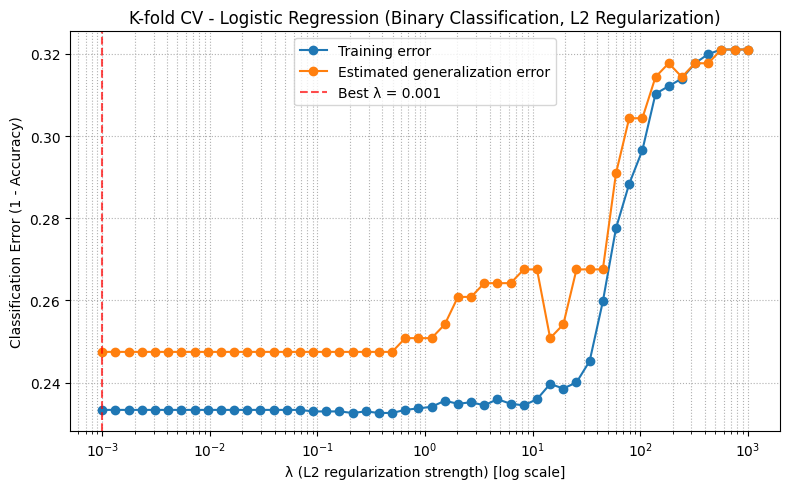

10-fold CV (Logistic Regression, L2 Regularization)
     lambda  train_err_mean  train_err_std  gen_err_est  test_err_std
   0.001000        0.233375       0.012447     0.247492      0.096775
   0.001326        0.233375       0.012447     0.247492      0.096775
   0.001758        0.233375       0.012447     0.247492      0.096775
   0.002330        0.233375       0.012447     0.247492      0.096775
   0.003089        0.233375       0.012447     0.247492      0.096775
   0.004095        0.233375       0.012447     0.247492      0.096775
   0.005429        0.233375       0.012447     0.247492      0.096775
   0.007197        0.233375       0.012447     0.247492      0.096775
   0.009541        0.233375       0.012447     0.247492      0.096775
   0.012649        0.233375       0.012447     0.247492      0.096775
   0.016768        0.233375       0.012447     0.247492      0.096775
   0.022230        0.233375       0.012447     0.247492      0.096775
   0.029471        0.233375       0.01

In [110]:
# Parameters
K = 10
kf = StratifiedKFold(n_splits=K, shuffle=True, random_state=42)
lambdas = np.logspace(-3, 3, 50)  # λ search grid
cols = X.columns.tolist()

# Containers
train_err_mean, train_err_std = [], []
gen_err_est, test_err_std = [], []

# Helper function for z-score standardization
def standardize_features(X_train_df, X_test_df, cols):
    """Standardize selected columns using train fold statistics."""
    mu = X_train_df[cols].mean(axis=0)
    sigma = X_train_df[cols].std(axis=0, ddof=0).replace(0, 1.0)

    X_train_std = X_train_df.copy()
    X_test_std = X_test_df.copy()

    for X_ in [X_train_std, X_test_std]:
        X_[cols] = X_[cols].astype("float64")
        X_.loc[:, cols] = (X_[cols] - mu) / sigma

    return X_train_std, X_test_std

# K-fold CV across λ values
N_total = len(X)
for lam in lambdas:
    fold_train_errs, fold_test_errs, fold_weights = [], [], []

    for train_idx, test_idx in kf.split(X, y):
        X_train, X_test = X.iloc[train_idx].copy(), X.iloc[test_idx].copy()
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        # Standardize features
        X_train, X_test = standardize_features(X_train, X_test, cols)

        # Fit Logistic Regression with L2 regularization
        model = LogisticRegression(
            penalty="l2",
            C=1/lam,
            solver="lbfgs",
            max_iter=1000,
            random_state=42
        )
        model.fit(X_train, y_train)

        # Compute classification error = 1 - accuracy
        train_err = 1 - accuracy_score(y_train, model.predict(X_train))
        test_err = 1 - accuracy_score(y_test, model.predict(X_test))

        fold_train_errs.append(train_err)
        fold_test_errs.append(test_err)
        fold_weights.append(len(test_idx) / N_total)

    # Aggregate fold errors
    train_err_mean.append(np.mean(fold_train_errs))
    train_err_std.append(np.std(fold_train_errs, ddof=1))
    gen_err_est.append(np.sum(np.array(fold_weights) * np.array(fold_test_errs)))
    test_err_std.append(np.std(fold_test_errs, ddof=1))

# Compile results
cv_table = pd.DataFrame({
    "lambda": lambdas,
    "train_err_mean": train_err_mean,
    "train_err_std": train_err_std,
    "gen_err_est": gen_err_est,
    "test_err_std": test_err_std,
})

best_idx = np.argmin(cv_table["gen_err_est"])
best_lambda = cv_table.loc[best_idx, "lambda"]
best_gen_err = cv_table.loc[best_idx, "gen_err_est"]

# Plot CV results
plt.figure(figsize=(8, 5))
plt.semilogx(lambdas, cv_table["train_err_mean"], "o-", label="Training error")
plt.semilogx(lambdas, cv_table["gen_err_est"], "o-", label="Estimated generalization error")
plt.axvline(best_lambda, linestyle="--", color="r", alpha=0.7, label=f"Best λ = {best_lambda:.3g}")
plt.xlabel("λ (L2 regularization strength) [log scale]")
plt.ylabel("Classification Error (1 - Accuracy)")
plt.title("K-fold CV - Logistic Regression (Binary Classification, L2 Regularization)")
plt.legend()
plt.grid(True, which="both", ls=":")
plt.tight_layout()
plt.show()

# Print Results
print("10-fold CV (Logistic Regression, L2 Regularization)")
print(cv_table.to_string(index=False, float_format=lambda v: f"{v:.6f}"))
print(f"\nBest λ (alpha): {best_lambda:.6g}")
print(f"Estimated generalization error (1 - accuracy): {best_gen_err:.6f}")


## Parameters

In [111]:
outer_folds_k_1 = 10
inner_folds_k_2 = 10
random_state = 42

# Hyperparameters to test
hyperparameters_tree = [2, 3, 4, 5, 6, 7]   
lambdas_logistic = np.logspace(-3, 3, 40)


In [112]:
print (lambdas_logistic)

[1.00000000e-03 1.42510267e-03 2.03091762e-03 2.89426612e-03
 4.12462638e-03 5.87801607e-03 8.37677640e-03 1.19377664e-02
 1.70125428e-02 2.42446202e-02 3.45510729e-02 4.92388263e-02
 7.01703829e-02 1.00000000e-01 1.42510267e-01 2.03091762e-01
 2.89426612e-01 4.12462638e-01 5.87801607e-01 8.37677640e-01
 1.19377664e+00 1.70125428e+00 2.42446202e+00 3.45510729e+00
 4.92388263e+00 7.01703829e+00 1.00000000e+01 1.42510267e+01
 2.03091762e+01 2.89426612e+01 4.12462638e+01 5.87801607e+01
 8.37677640e+01 1.19377664e+02 1.70125428e+02 2.42446202e+02
 3.45510729e+02 4.92388263e+02 7.01703829e+02 1.00000000e+03]


## Cross_Validation

In [113]:
CV_outer = StratifiedKFold(n_splits=outer_folds_k_1, shuffle=True, random_state=random_state)

fold_results = {}
best_hyperparameters_logistic = {}
best_hyperparameters_tree = {}
outer_fold_index = 0

for outer_train_idx, outer_test_idx in CV_outer.split(X, y):
    outer_fold_index += 1
    print(f"  OUTER FOLD {outer_fold_index}")

    ############################ DATA Outer Fold ####################################

    X_train_outer, X_test_outer, y_train_outer, y_test_outer = get_fold_data(X, y, outer_train_idx, outer_test_idx)

    CV_inner = StratifiedKFold(n_splits=inner_folds_k_2, shuffle=True, random_state=outer_fold_index)
    inner_acc_baseline = {}
    inner_acc_logistic = {}
    inner_acc_tree = {}
    inner_fold_index = 0

    for inner_train_idx, inner_test_idx in CV_inner.split(X_train_outer, y_train_outer):
        inner_fold_index += 1
        print(f"Outer Fold {outer_fold_index} - Inner Fold {inner_fold_index}")

        ############################ DATA Inner Fold ####################################

        X_train_inner_norm, X_test_inner_norm, y_train_inner_norm, y_test_inner_norm = get_fold_data_normalized(X_train_outer, y_train_outer, inner_train_idx, inner_test_idx)

        ############################# LOGISTIC REGRESSION Inner Fold ####################################
        results_inner_logistic = {lam: {'val_error': []} for lam in lambdas_logistic}

        for lam in lambdas_logistic:
            model = LogisticRegression(penalty="l2", C=1/lam, solver="lbfgs", max_iter=1000, random_state=random_state)
            model.fit(X_train_inner_norm, y_train_inner_norm)
            y_val_pred = model.predict(X_test_inner_norm)
            val_error = zero_one_loss(y_test_inner_norm, y_val_pred)
            results_inner_logistic[lam]['val_error'].append(val_error)

        inner_acc_logistic[inner_fold_index] = results_inner_logistic

        ############################# DECISION TREE Inner Fold ####################################

        results_inner_tree = {depth: {'val_error': []} for depth in hyperparameters_tree}

        for depth in hyperparameters_tree:
            tree = DecisionTreeClassifier(max_depth=depth, criterion='log_loss', random_state=random_state)
            tree.fit(X_train_inner_norm, y_train_inner_norm)
            y_val_pred = tree.predict(X_test_inner_norm)
            val_error = zero_one_loss(y_test_inner_norm, y_val_pred)
            results_inner_tree[depth]['val_error'].append(val_error)

        inner_acc_tree[inner_fold_index] = results_inner_tree

        ############################# BASELINE Inner Fold (REMOVED) ####################################

        # -----

        ######################## OUTER FOLD ##########################################################

    ############################ Data ####################################

    X_train_outer_norm, X_test_outer_norm, y_train_outer_norm, y_test_outer_norm = get_fold_data_normalized(X, y, outer_train_idx, outer_test_idx)

    ############################# LOGISTIC REGRESSION Outer Fold ####################################

    avg_val_error_per_lambda = {}
    for lam in lambdas_logistic:
        val_errors = []
        for inner_fold in inner_acc_logistic.keys():
            val_errors.extend(inner_acc_logistic[inner_fold][lam]['val_error'])
        avg_val_error_per_lambda[lam] = np.mean(val_errors)

    best_lambda = min(avg_val_error_per_lambda, key=avg_val_error_per_lambda.get)
    best_hyperparameters_logistic[outer_fold_index] = best_lambda
    print(f"  ▶ Best λ (regularization): {best_lambda:.5f}")

    final_model = LogisticRegression( penalty="l2", C=1/best_lambda, solver="lbfgs", max_iter=1000, random_state=random_state)
    final_model.fit(X_train_outer_norm, y_train_outer_norm)
    y_test_pred = final_model.predict(X_test_outer_norm)
    outer_test_error = zero_one_loss(y_test_outer_norm, y_test_pred)
    outer_test_acc = accuracy_score(y_test_outer_norm, y_test_pred)
    outer_test_mcc = matthews_corrcoef(y_test_outer_norm, y_test_pred)

    print(f"  Logistic Regression Outer Test Accuracy: {outer_test_acc:.4f} | "    f"Error: {outer_test_error:.4f} | MCC: {outer_test_mcc:.4f}")
    ############################# DECISION TREE Outer Fold ####################################

    avg_val_error_per_depth = {depth: np.mean([err for fold in inner_acc_tree.keys() for err in inner_acc_tree[fold][depth]['val_error']]) for depth in hyperparameters_tree}

    best_depth = min(avg_val_error_per_depth, key=avg_val_error_per_depth.get)
    best_hyperparameters_tree[outer_fold_index] = best_depth
    print(f"  ▶ Best Tree Depth: {best_depth}")

    final_tree = DecisionTreeClassifier(max_depth=best_depth, criterion='log_loss', random_state=random_state)
    final_tree.fit(X_train_outer_norm, y_train_outer_norm)
    y_test_pred_tree = final_tree.predict(X_test_outer_norm)
    outer_test_error_tree = zero_one_loss(y_test_outer_norm, y_test_pred_tree)
    outer_test_acc_tree = accuracy_score(y_test_outer_norm, y_test_pred_tree)

    ############################# BASELINE Outer Fold ####################################

    majority_class_outer = y_train_outer_norm.mode()[0]
    y_pred_baseline_outer = np.full_like(y_test_outer_norm, fill_value=majority_class_outer)
    baseline_acc_outer = accuracy_score(y_test_outer_norm, y_pred_baseline_outer)
    baseline_error_outer = zero_one_loss(y_test_outer_norm, y_pred_baseline_outer)


    ############################# STORE RESULTS ####################################
    fold_results[outer_fold_index] = {
        "baseline_outer_error": baseline_error_outer,
        "logistic_best_lambda": best_lambda,
        "logistic_outer_error": outer_test_error,
        "logistic_outer_mcc": outer_test_mcc, 
        "tree_best_depth": best_depth,
        "tree_outer_error": outer_test_error_tree
    }

    print(f"Finished Outer Fold {outer_fold_index}")

print("Nested CV Completed")
print("Best Logistic Regression λ per fold:")
print(best_hyperparameters_logistic)
print("Best Tree Depth per fold:")
print(best_hyperparameters_tree)

outer_results_df = pd.DataFrame.from_dict(fold_results, orient='index')
print("\n=== Summary of Outer Fold Results ===")
print(outer_results_df)


  OUTER FOLD 1
Outer Fold 1 - Inner Fold 1
Outer Fold 1 - Inner Fold 2
Outer Fold 1 - Inner Fold 3
Outer Fold 1 - Inner Fold 4
Outer Fold 1 - Inner Fold 5
Outer Fold 1 - Inner Fold 6
Outer Fold 1 - Inner Fold 7
Outer Fold 1 - Inner Fold 8
Outer Fold 1 - Inner Fold 9
Outer Fold 1 - Inner Fold 10
  ▶ Best λ (regularization): 10.00000
  Logistic Regression Outer Test Accuracy: 0.7000 | Error: 0.3000 | MCC: 0.2357
  ▶ Best Tree Depth: 2
Finished Outer Fold 1
  OUTER FOLD 2
Outer Fold 2 - Inner Fold 1
Outer Fold 2 - Inner Fold 2
Outer Fold 2 - Inner Fold 3
Outer Fold 2 - Inner Fold 4
Outer Fold 2 - Inner Fold 5
Outer Fold 2 - Inner Fold 6
Outer Fold 2 - Inner Fold 7
Outer Fold 2 - Inner Fold 8
Outer Fold 2 - Inner Fold 9
Outer Fold 2 - Inner Fold 10
  ▶ Best λ (regularization): 0.00100
  Logistic Regression Outer Test Accuracy: 0.6000 | Error: 0.4000 | MCC: 0.0000
  ▶ Best Tree Depth: 4
Finished Outer Fold 2
  OUTER FOLD 3
Outer Fold 3 - Inner Fold 1
Outer Fold 3 - Inner Fold 2
Outer Fold 3

In [114]:
mcc_values = [fold_results[fold]["logistic_outer_mcc"] for fold in fold_results]
mean_outer_test_mcc = np.mean(mcc_values)
print(f"Mean outer test MCC across folds: {mean_outer_test_mcc:.4f}")

Mean outer test MCC across folds: 0.3341


In [115]:
def count_best_parameters(dict_parameters_for_each_outer_fold):
    count_parameter_dict = {}
    for outer_fold_index in dict_parameters_for_each_outer_fold.keys():
        value = dict_parameters_for_each_outer_fold.get(outer_fold_index)
        if value not in count_parameter_dict:
            count_parameter_dict[value] = 1
        else:
            count_parameter_dict[value] += 1
    return count_parameter_dict

def best_parameter(count_parameter_dict):
    best_param = max(count_parameter_dict, key=count_parameter_dict.get)
    return best_param

In [116]:
# Use best hyperparameters obtained from nested CV based on frequency (mode)
best_lambda = best_parameter(count_best_parameters(best_hyperparameters_logistic))
best_depth = best_parameter(count_best_parameters(best_hyperparameters_tree))

print("Best λ (regularization) for Logistic Regression across all outer folds:", best_lambda)
print("Best max_depth for Decision Tree across all outer folds:", best_depth)

Best λ (regularization) for Logistic Regression across all outer folds: 20.30917620904739
Best max_depth for Decision Tree across all outer folds: 2


## Statistical Test


### Auxiliary functions

In [117]:
m = 10        # Repetitions
K = 10        # Folds
rho = 1 / K   # Correlation heuristic
alpha = 0.05  # Significance level

# Parameters used
best_lambda_statistic_test = best_lambda
best_depth_statistic_test = best_depth

### Logistic Regression vs Decision Tree

In [118]:

r = []
err_logistic_all = []
err_tree_all = []

for repeat_idx in range(m):
    print(f"Repetition {repeat_idx+1}/{m}")
    CV_kfold = StratifiedKFold(n_splits=K, shuffle=True, random_state=repeat_idx)

    for fold, (train_index, test_index) in tqdm(
        enumerate(CV_kfold.split(X, y)), total=K, desc="Cross-validation fold"
    ):
        # Data normalization
        X_train_norm, X_test_norm, y_train_norm, y_test_norm = get_fold_data_normalized(X, y, train_index, test_index)

        # Logistic Regression
        model_logistic = LogisticRegression(
            penalty="l2", C=1 / best_lambda_statistic_test, solver="lbfgs", max_iter=1000, random_state=repeat_idx
        )
        model_logistic.fit(X_train_norm, y_train_norm)
        y_pred_logistic = model_logistic.predict(X_test_norm)
        err_logistic = classification_error(y_test_norm, y_pred_logistic)
        err_logistic_all.append(err_logistic)

        # Decision Tree
        model_tree = DecisionTreeClassifier(
            max_depth=int(best_depth_statistic_test), criterion="log_loss", random_state=repeat_idx
        )
        model_tree.fit(X_train_norm, y_train_norm)
        y_pred_tree = model_tree.predict(X_test_norm)
        err_tree = classification_error(y_test_norm, y_pred_tree)
        err_tree_all.append(err_tree)

        # Difference in performance (positive means logistic better)
        r_j = err_tree - err_logistic
        r.append(r_j)

# After the loop, compute the correlated t-test
r_hat, CI, p_value = correlated_ttest(r, rho, alpha=alpha)
print(f"\nr̂ (mean diff): {r_hat:.4f}")
print(f"95% CI: [{CI[0]:.4f}, {CI[1]:.4f}]")
print(f"p-value: {p_value:.4f}")

# Optional: model performance summary
print(f"\nMean Logistic Regression accuracy: {1 - np.mean(err_logistic_all):.4f}")
print(f"Mean Decision Tree accuracy:        {1 - np.mean(err_tree_all):.4f}")


Repetition 1/10


Cross-validation fold: 100%|██████████| 10/10 [00:00<00:00, 133.28it/s]


Repetition 2/10


Cross-validation fold: 100%|██████████| 10/10 [00:00<00:00, 116.72it/s]


Repetition 3/10


Cross-validation fold: 100%|██████████| 10/10 [00:00<00:00, 144.41it/s]


Repetition 4/10


Cross-validation fold: 100%|██████████| 10/10 [00:00<00:00, 137.17it/s]


Repetition 5/10


Cross-validation fold: 100%|██████████| 10/10 [00:00<00:00, 163.15it/s]


Repetition 6/10


Cross-validation fold: 100%|██████████| 10/10 [00:00<00:00, 124.23it/s]


Repetition 7/10


Cross-validation fold: 100%|██████████| 10/10 [00:00<00:00, 148.59it/s]


Repetition 8/10


Cross-validation fold: 100%|██████████| 10/10 [00:00<00:00, 115.52it/s]


Repetition 9/10


Cross-validation fold: 100%|██████████| 10/10 [00:00<00:00, 146.25it/s]


Repetition 10/10


Cross-validation fold: 100%|██████████| 10/10 [00:00<00:00, 130.07it/s]


r̂ (mean diff): 0.0175
95% CI: [-0.0270, 0.0620]
p-value: 0.4368

Mean Logistic Regression accuracy: 0.7419
Mean Decision Tree accuracy:        0.7244


### Baseline vs Logistic Regression

In [119]:
r = []
print("\n=== Statistical Comparison: Baseline vs Logistic Regression ===")

for repeat_idx in range(m):
    print(f"Repetition {repeat_idx+1}/{m}")
    CV_kfold = StratifiedKFold(n_splits=K, shuffle=True, random_state=repeat_idx)

    for fold, (train_index, test_index) in tqdm(
        enumerate(CV_kfold.split(X,y)), total=K, desc="Cross-validation fold"
    ):
        # Data normalization
        X_train_norm, X_test_norm, y_train_norm, y_test_norm = get_fold_data_normalized(X, y, train_index, test_index)

        # Baseline
        majority_class = y_train_norm.mode()[0]
        y_pred_baseline = np.full_like(y_test_norm, fill_value=majority_class)
        err_baseline = classification_error(y_test_norm, y_pred_baseline)

        # Logistic Regression
        model_logistic = LogisticRegression(
            penalty="l2", C=1/best_lambda_statistic_test, solver="lbfgs", max_iter=1000, random_state=repeat_idx
        )
        model_logistic.fit(X_train_norm, y_train_norm)
        y_pred_logistic = model_logistic.predict(X_test_norm)
        err_logistic = classification_error(y_test_norm, y_pred_logistic)

        # Difference in performance
        r_j = err_baseline - err_logistic
        r.append(r_j)

r_hat, CI, p_value = correlated_ttest(r, rho, alpha=alpha)
print(f"\nr̂ (mean diff): {r_hat:.4f}")
print(f"95% CI: [{CI[0]:.4f}, {CI[1]:.4f}]")
print(f"p-value: {p_value:.4f}")




=== Statistical Comparison: Baseline vs Logistic Regression ===
Repetition 1/10


Cross-validation fold: 100%|██████████| 10/10 [00:00<00:00, 141.24it/s]


Repetition 2/10


Cross-validation fold: 100%|██████████| 10/10 [00:00<00:00, 178.41it/s]


Repetition 3/10


Cross-validation fold: 100%|██████████| 10/10 [00:00<00:00, 201.74it/s]


Repetition 4/10


Cross-validation fold: 100%|██████████| 10/10 [00:00<00:00, 194.74it/s]


Repetition 5/10


Cross-validation fold: 100%|██████████| 10/10 [00:00<00:00, 143.00it/s]


Repetition 6/10


Cross-validation fold: 100%|██████████| 10/10 [00:00<00:00, 198.31it/s]


Repetition 7/10


Cross-validation fold: 100%|██████████| 10/10 [00:00<00:00, 157.20it/s]


Repetition 8/10


Cross-validation fold: 100%|██████████| 10/10 [00:00<00:00, 201.03it/s]


Repetition 9/10


Cross-validation fold: 100%|██████████| 10/10 [00:00<00:00, 198.48it/s]


Repetition 10/10


Cross-validation fold: 100%|██████████| 10/10 [00:00<00:00, 145.93it/s]


r̂ (mean diff): 0.0629
95% CI: [0.0243, 0.1016]
p-value: 0.0017


### Baseline vs Decision Tree

In [120]:
r = []
print("\n=== Statistical Comparison: Baseline vs Decision Tree ===")

for repeat_idx in range(m):
    print(f"Repetition {repeat_idx+1}/{m}")
    CV_kfold = StratifiedKFold(n_splits=K, shuffle=True, random_state=repeat_idx)

    for fold, (train_index, test_index) in tqdm(
        enumerate(CV_kfold.split(X, y)), total=K, desc="Cross-validation fold"
    ):
        # Data normalization
        X_train_norm, X_test_norm, y_train_norm, y_test_norm = get_fold_data_normalized(X, y, train_index, test_index)

        # Baseline
        majority_class = y_train_norm.mode()[0]
        y_pred_baseline = np.full_like(y_test_norm, fill_value=majority_class)
        err_baseline = classification_error(y_test_norm, y_pred_baseline)

        # Decision Tree
        model_tree = DecisionTreeClassifier(
            max_depth=int(best_depth_statistic_test), criterion="log_loss", random_state=repeat_idx
        )
        model_tree.fit(X_train_norm, y_train_norm)
        y_pred_tree = model_tree.predict(X_test_norm)
        err_tree = classification_error(y_test_norm, y_pred_tree)

        # Difference in performance
        r_j = err_baseline - err_tree
        r.append(r_j)

r_hat, CI, p_value = correlated_ttest(r, rho, alpha=alpha)
print(f"\nr̂ (mean diff): {r_hat:.4f}")
print(f"95% CI: [{CI[0]:.4f}, {CI[1]:.4f}]")
print(f"p-value: {p_value:.4f}")



=== Statistical Comparison: Baseline vs Decision Tree ===
Repetition 1/10


Cross-validation fold: 100%|██████████| 10/10 [00:00<00:00, 266.70it/s]


Repetition 2/10


Cross-validation fold: 100%|██████████| 10/10 [00:00<00:00, 303.97it/s]


Repetition 3/10


Cross-validation fold: 100%|██████████| 10/10 [00:00<00:00, 199.61it/s]


Repetition 4/10


Cross-validation fold: 100%|██████████| 10/10 [00:00<00:00, 204.90it/s]


Repetition 5/10


Cross-validation fold: 100%|██████████| 10/10 [00:00<00:00, 204.59it/s]


Repetition 6/10


Cross-validation fold: 100%|██████████| 10/10 [00:00<00:00, 200.94it/s]


Repetition 7/10


Cross-validation fold: 100%|██████████| 10/10 [00:00<00:00, 154.18it/s]


Repetition 8/10


Cross-validation fold: 100%|██████████| 10/10 [00:00<00:00, 197.99it/s]


Repetition 9/10


Cross-validation fold: 100%|██████████| 10/10 [00:00<00:00, 202.67it/s]


Repetition 10/10


Cross-validation fold: 100%|██████████| 10/10 [00:00<00:00, 188.23it/s]


r̂ (mean diff): 0.0454
95% CI: [-0.0012, 0.0921]
p-value: 0.0561


# with time 

In [121]:
name_data_file="heart_failure_clinical_records_dataset"

data = pd.read_csv(f"../../raw_data/{name_data_file}.csv", na_values=["?"])

In [122]:
# Split the data frame into features and labels
X = data.drop(columns=[ "DEATH_EVENT"])
y = data["DEATH_EVENT"]

N, M = X.shape
print(f"Data loaded: {N} samples, {M} features")

Data loaded: 299 samples, 12 features


## Auxiliary Functions

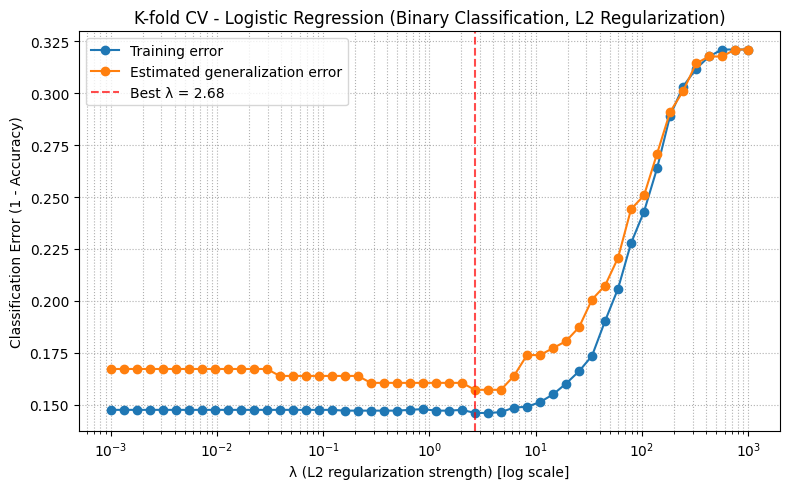

10-fold CV (Logistic Regression, L2 Regularization)
     lambda  train_err_mean  train_err_std  gen_err_est  test_err_std
   0.001000        0.147531       0.008638     0.167224      0.074550
   0.001326        0.147531       0.008638     0.167224      0.074550
   0.001758        0.147531       0.008638     0.167224      0.074550
   0.002330        0.147531       0.008638     0.167224      0.074550
   0.003089        0.147531       0.008638     0.167224      0.074550
   0.004095        0.147531       0.008638     0.167224      0.074550
   0.005429        0.147531       0.008638     0.167224      0.074550
   0.007197        0.147531       0.008638     0.167224      0.074550
   0.009541        0.147531       0.008638     0.167224      0.074550
   0.012649        0.147531       0.008638     0.167224      0.074550
   0.016768        0.147531       0.008638     0.167224      0.074550
   0.022230        0.147531       0.008638     0.167224      0.074550
   0.029471        0.147531       0.00

In [123]:
# Parameters
K = 10
kf = StratifiedKFold(n_splits=K, shuffle=True, random_state=42)
lambdas = np.logspace(-3, 3, 50)  # λ search grid
cols = X.columns.tolist()

# Containers
train_err_mean, train_err_std = [], []
gen_err_est, test_err_std = [], []

# Helper function for z-score standardization
def standardize_features(X_train_df, X_test_df, cols):
    """Standardize selected columns using train fold statistics."""
    mu = X_train_df[cols].mean(axis=0)
    sigma = X_train_df[cols].std(axis=0, ddof=0).replace(0, 1.0)

    X_train_std = X_train_df.copy()
    X_test_std = X_test_df.copy()

    for X_ in [X_train_std, X_test_std]:
        X_[cols] = X_[cols].astype("float64")
        X_.loc[:, cols] = (X_[cols] - mu) / sigma

    return X_train_std, X_test_std

# K-fold CV across λ values
N_total = len(X)
for lam in lambdas:
    fold_train_errs, fold_test_errs, fold_weights = [], [], []

    for train_idx, test_idx in kf.split(X, y):
        X_train, X_test = X.iloc[train_idx].copy(), X.iloc[test_idx].copy()
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        # Standardize features
        X_train, X_test = standardize_features(X_train, X_test, cols)

        # Fit Logistic Regression with L2 regularization
        model = LogisticRegression(
            penalty="l2",
            C=1/lam,
            solver="lbfgs",
            max_iter=1000,
            random_state=42
        )
        model.fit(X_train, y_train)

        # Compute classification error = 1 - accuracy
        train_err = 1 - accuracy_score(y_train, model.predict(X_train))
        test_err = 1 - accuracy_score(y_test, model.predict(X_test))

        fold_train_errs.append(train_err)
        fold_test_errs.append(test_err)
        fold_weights.append(len(test_idx) / N_total)

    # Aggregate fold errors
    train_err_mean.append(np.mean(fold_train_errs))
    train_err_std.append(np.std(fold_train_errs, ddof=1))
    gen_err_est.append(np.sum(np.array(fold_weights) * np.array(fold_test_errs)))
    test_err_std.append(np.std(fold_test_errs, ddof=1))

# Compile results
cv_table = pd.DataFrame({
    "lambda": lambdas,
    "train_err_mean": train_err_mean,
    "train_err_std": train_err_std,
    "gen_err_est": gen_err_est,
    "test_err_std": test_err_std,
})

best_idx = np.argmin(cv_table["gen_err_est"])
best_lambda = cv_table.loc[best_idx, "lambda"]
best_gen_err = cv_table.loc[best_idx, "gen_err_est"]

# Plot CV results
plt.figure(figsize=(8, 5))
plt.semilogx(lambdas, cv_table["train_err_mean"], "o-", label="Training error")
plt.semilogx(lambdas, cv_table["gen_err_est"], "o-", label="Estimated generalization error")
plt.axvline(best_lambda, linestyle="--", color="r", alpha=0.7, label=f"Best λ = {best_lambda:.3g}")
plt.xlabel("λ (L2 regularization strength) [log scale]")
plt.ylabel("Classification Error (1 - Accuracy)")
plt.title("K-fold CV - Logistic Regression (Binary Classification, L2 Regularization)")
plt.legend()
plt.grid(True, which="both", ls=":")
plt.tight_layout()
plt.show()

# Print Results
print("10-fold CV (Logistic Regression, L2 Regularization)")
print(cv_table.to_string(index=False, float_format=lambda v: f"{v:.6f}"))
print(f"\nBest λ (alpha): {best_lambda:.6g}")
print(f"Estimated generalization error (1 - accuracy): {best_gen_err:.6f}")


## Parameters

In [124]:
outer_folds_k_1 = 10
inner_folds_k_2 = 10
random_state = 42

# Hyperparameters to test
hyperparameters_tree = [2, 3, 4, 5, 6, 7]   
lambdas_logistic = np.logspace(-3, 3, 40)


## Cross_Validation

In [125]:
CV_outer = StratifiedKFold(n_splits=outer_folds_k_1, shuffle=True, random_state=random_state)

fold_results = {}
best_hyperparameters_logistic = {}
best_hyperparameters_tree = {}
outer_fold_index = 0

for outer_train_idx, outer_test_idx in CV_outer.split(X, y):
    outer_fold_index += 1
    print(f"  OUTER FOLD {outer_fold_index}")

    ############################ DATA Outer Fold ####################################

    X_train_outer, X_test_outer, y_train_outer, y_test_outer = get_fold_data(X, y, outer_train_idx, outer_test_idx)

    CV_inner = StratifiedKFold(n_splits=inner_folds_k_2, shuffle=True, random_state=outer_fold_index)
    inner_acc_baseline = {}
    inner_acc_logistic = {}
    inner_acc_tree = {}
    inner_fold_index = 0

    for inner_train_idx, inner_test_idx in CV_inner.split(X_train_outer, y_train_outer):
        inner_fold_index += 1
        print(f"Outer Fold {outer_fold_index} - Inner Fold {inner_fold_index}")

        ############################ DATA Inner Fold ####################################

        X_train_inner_norm, X_test_inner_norm, y_train_inner_norm, y_test_inner_norm = get_fold_data_normalized(X_train_outer, y_train_outer, inner_train_idx, inner_test_idx)

        ############################# LOGISTIC REGRESSION Inner Fold ####################################
        results_inner_logistic = {lam: {'val_error': []} for lam in lambdas_logistic}

        for lam in lambdas_logistic:
            model = LogisticRegression(penalty="l2", C=1/lam, solver="lbfgs", max_iter=1000, random_state=random_state)
            model.fit(X_train_inner_norm, y_train_inner_norm)
            y_val_pred = model.predict(X_test_inner_norm)
            val_error = zero_one_loss(y_test_inner_norm, y_val_pred)
            results_inner_logistic[lam]['val_error'].append(val_error)

        inner_acc_logistic[inner_fold_index] = results_inner_logistic

        ############################# DECISION TREE Inner Fold ####################################

        results_inner_tree = {depth: {'val_error': []} for depth in hyperparameters_tree}

        for depth in hyperparameters_tree:
            tree = DecisionTreeClassifier(max_depth=depth, criterion='log_loss', random_state=random_state)
            tree.fit(X_train_inner_norm, y_train_inner_norm)
            y_val_pred = tree.predict(X_test_inner_norm)
            val_error = zero_one_loss(y_test_inner_norm, y_val_pred)
            results_inner_tree[depth]['val_error'].append(val_error)

        inner_acc_tree[inner_fold_index] = results_inner_tree

        ############################# BASELINE Inner Fold (REMOVED) ####################################

        # -----

        ######################## OUTER FOLD ##########################################################

    ############################ Data ####################################

    X_train_outer_norm, X_test_outer_norm, y_train_outer_norm, y_test_outer_norm = get_fold_data_normalized(X, y, outer_train_idx, outer_test_idx)

    ############################# LOGISTIC REGRESSION Outer Fold ####################################

    avg_val_error_per_lambda = {}
    for lam in lambdas_logistic:
        val_errors = []
        for inner_fold in inner_acc_logistic.keys():
            val_errors.extend(inner_acc_logistic[inner_fold][lam]['val_error'])
        avg_val_error_per_lambda[lam] = np.mean(val_errors)

    best_lambda = min(avg_val_error_per_lambda, key=avg_val_error_per_lambda.get)
    best_hyperparameters_logistic[outer_fold_index] = best_lambda
    print(f"  ▶ Best λ (regularization): {best_lambda:.5f}")

    final_model = LogisticRegression( penalty="l2", C=1/best_lambda, solver="lbfgs", max_iter=1000, random_state=random_state)
    final_model.fit(X_train_outer_norm, y_train_outer_norm)
    y_test_pred = final_model.predict(X_test_outer_norm)
    outer_test_error = zero_one_loss(y_test_outer_norm, y_test_pred)
    outer_test_acc = accuracy_score(y_test_outer_norm, y_test_pred)
    outer_test_mcc = matthews_corrcoef(y_test_outer_norm, y_test_pred)

    print(f"  Logistic Regression Outer Test Accuracy: {outer_test_acc:.4f} | "    f"Error: {outer_test_error:.4f} | MCC: {outer_test_mcc:.4f}")
    ############################# DECISION TREE Outer Fold ####################################

    avg_val_error_per_depth = {depth: np.mean([err for fold in inner_acc_tree.keys() for err in inner_acc_tree[fold][depth]['val_error']]) for depth in hyperparameters_tree}

    best_depth = min(avg_val_error_per_depth, key=avg_val_error_per_depth.get)
    best_hyperparameters_tree[outer_fold_index] = best_depth
    print(f"  ▶ Best Tree Depth: {best_depth}")

    final_tree = DecisionTreeClassifier(max_depth=best_depth, criterion='log_loss', random_state=random_state)
    final_tree.fit(X_train_outer_norm, y_train_outer_norm)
    y_test_pred_tree = final_tree.predict(X_test_outer_norm)
    outer_test_error_tree = zero_one_loss(y_test_outer_norm, y_test_pred_tree)
    outer_test_acc_tree = accuracy_score(y_test_outer_norm, y_test_pred_tree)

    ############################# BASELINE Outer Fold ####################################

    majority_class_outer = y_train_outer_norm.mode()[0]
    y_pred_baseline_outer = np.full_like(y_test_outer_norm, fill_value=majority_class_outer)
    baseline_acc_outer = accuracy_score(y_test_outer_norm, y_pred_baseline_outer)
    baseline_error_outer = zero_one_loss(y_test_outer_norm, y_pred_baseline_outer)


    ############################# STORE RESULTS ####################################
    fold_results[outer_fold_index] = {
        "baseline_outer_error": baseline_error_outer,
        "logistic_best_lambda": best_lambda,
        "logistic_outer_error": outer_test_error,
        "logistic_outer_mcc": outer_test_mcc, 
        "tree_best_depth": best_depth,
        "tree_outer_error": outer_test_error_tree
    }

    print(f"Finished Outer Fold {outer_fold_index}")


  OUTER FOLD 1
Outer Fold 1 - Inner Fold 1
Outer Fold 1 - Inner Fold 2
Outer Fold 1 - Inner Fold 3
Outer Fold 1 - Inner Fold 4
Outer Fold 1 - Inner Fold 5
Outer Fold 1 - Inner Fold 6
Outer Fold 1 - Inner Fold 7
Outer Fold 1 - Inner Fold 8
Outer Fold 1 - Inner Fold 9
Outer Fold 1 - Inner Fold 10
  ▶ Best λ (regularization): 2.42446
  Logistic Regression Outer Test Accuracy: 0.7667 | Error: 0.2333 | MCC: 0.4458
  ▶ Best Tree Depth: 5
Finished Outer Fold 1
  OUTER FOLD 2
Outer Fold 2 - Inner Fold 1
Outer Fold 2 - Inner Fold 2
Outer Fold 2 - Inner Fold 3
Outer Fold 2 - Inner Fold 4
Outer Fold 2 - Inner Fold 5
Outer Fold 2 - Inner Fold 6
Outer Fold 2 - Inner Fold 7
Outer Fold 2 - Inner Fold 8
Outer Fold 2 - Inner Fold 9
Outer Fold 2 - Inner Fold 10
  ▶ Best λ (regularization): 3.45511
  Logistic Regression Outer Test Accuracy: 0.8667 | Error: 0.1333 | MCC: 0.7217
  ▶ Best Tree Depth: 2
Finished Outer Fold 2
  OUTER FOLD 3
Outer Fold 3 - Inner Fold 1
Outer Fold 3 - Inner Fold 2
Outer Fold 3 

In [126]:
outer_results_df = pd.DataFrame.from_dict(fold_results, orient='index')
print("\n Summary of Outer Fold Results")
print(outer_results_df)


 Summary of Outer Fold Results
    baseline_outer_error  logistic_best_lambda  logistic_outer_error  \
1               0.333333              2.424462              0.233333   
2               0.333333              3.455107              0.133333   
3               0.333333              4.923883              0.233333   
4               0.333333              0.001000              0.066667   
5               0.333333              1.701254              0.100000   
6               0.333333              4.923883              0.200000   
7               0.300000              1.193777              0.066667   
8               0.300000             14.251027              0.133333   
9               0.300000              0.001000              0.233333   
10              0.310345              7.017038              0.241379   

    logistic_outer_mcc  tree_best_depth  tree_outer_error  
1             0.445823                5          0.233333  
2             0.721688                2          0.0333

In [127]:
mcc_values = [fold_results[fold]["logistic_outer_mcc"] for fold in fold_results]
mean_outer_test_mcc = np.mean(mcc_values)
print(f"Mean outer test MCC across folds: {mean_outer_test_mcc:.4f}")

Mean outer test MCC across folds: 0.6122


In [128]:
def count_best_parameters(dict_parameters_for_each_outer_fold):
    count_parameter_dict = {}
    for outer_fold_index in dict_parameters_for_each_outer_fold.keys():
        value = dict_parameters_for_each_outer_fold.get(outer_fold_index)
        if value not in count_parameter_dict:
            count_parameter_dict[value] = 1
        else:
            count_parameter_dict[value] += 1
    return count_parameter_dict

def best_parameter(count_parameter_dict):
    best_param = max(count_parameter_dict, key=count_parameter_dict.get)
    return best_param

In [129]:
# Use best hyperparameters obtained from nested CV based on frequency (mode)
best_lambda = best_parameter(count_best_parameters(best_hyperparameters_logistic))
best_depth = best_parameter(count_best_parameters(best_hyperparameters_tree))

print("Best λ (regularization) for Logistic Regression across all outer folds:", best_lambda)
print("Best max_depth for Decision Tree across all outer folds:", best_depth)

Best λ (regularization) for Logistic Regression across all outer folds: 4.923882631706742
Best max_depth for Decision Tree across all outer folds: 2


In [28]:
# patient example
patient_idx = 32  # can be altered
x_example = X.iloc[patient_idx]
x_std = (x_example - X.mean()) / X.std(ddof=0)
y_true = y.iloc[patient_idx]

# coeficients and beta0
coefs = final_model.coef_.flatten()
intercept = final_model.intercept_[0]
features = X.columns

# logit e probability
logit_value = intercept + np.dot(x_std, coefs)
prob = 1 / (1 + np.exp(-logit_value))
y_pred = int(prob >= 0.5)

# results
print("=== Example prediction (patient index {}) ===".format(patient_idx))
print(f"True class (y):                {int(y_true)}")
print(f"Predicted class (ŷ):           {y_pred}")
print(f"Predicted probability P(y=1):  {prob:.4f}")
print(f"Logit value (β₀ + Σβx):        {logit_value:.4f}\n")

# equation 
equation_terms = [f"{coef:+.3f}·{feat}" for coef, feat in zip(coefs, features)]
equation_str = " + ".join(equation_terms)
print("=== Algebraic form of the final Logistic Regression model ===\n")
print(f"logit(p) = {intercept:+.3f} {equation_str}")

# weights and contributions
contributions = coefs * x_std
contrib_df = pd.DataFrame({
    "feature": features,
    "x_value (standardized)": x_std.values,
    "coef": coefs,
    "contribution (coef*x)": contributions,
    "effect": np.where(coefs > 0, "↑ increases P(y=1)", "↓ decreases P(y=1)")
}).sort_values("contribution (coef*x)", ascending=False)

print("\n === Feature contributions to logit(p) ===")
print(contrib_df.to_string(index=False, float_format=lambda v: f"{v: .3f}"))

=== Example prediction (patient index 32) ===
True class (y):                1
Predicted class (ŷ):           0
Predicted probability P(y=1):  0.4048
Logit value (β₀ + Σβx):        -0.3857

=== Algebraic form of the final Logistic Regression model ===

logit(p) = -0.899 +0.474·age + +0.200·anaemia + +0.194·creatinine_phosphokinase + -0.006·diabetes + -0.611·ejection_fraction + +0.130·high_blood_pressure + -0.125·platelets + +0.453·serum_creatinine + -0.246·serum_sodium + -0.152·sex + -0.014·smoking

 === Feature contributions to logit(p) ===
                 feature  x_value (standardized)   coef  contribution (coef*x)             effect
            serum_sodium                  -1.958 -0.246                  0.481 ↓ decreases P(y=1)
                 anaemia                   1.148  0.200                  0.230 ↑ increases P(y=1)
                     sex                  -1.359 -0.152                  0.206 ↓ decreases P(y=1)
     high_blood_pressure                   1.359  0.130     

## Statistical Test

In [130]:
m = 10        # Repetitions
K = 10        # Folds
rho = 1 / K   # Correlation heuristic
alpha = 0.05  # Significance level

# Parameters used
best_lambda_statistic_test = best_lambda
best_depth_statistic_test = best_depth

##  Logistic Regression vs Decision Tree 

In [131]:
r = []
err_logistic_all = []
err_tree_all = []

for repeat_idx in range(m):
    print(f"Repetition {repeat_idx+1}/{m}")
    CV_kfold = StratifiedKFold(n_splits=K, shuffle=True, random_state=repeat_idx)

    for fold, (train_index, test_index) in tqdm(
        enumerate(CV_kfold.split(X, y)), total=K, desc="Cross-validation fold"
    ):
        # Data normalization
        X_train_norm, X_test_norm, y_train_norm, y_test_norm = get_fold_data_normalized(X, y, train_index, test_index)

        # Logistic Regression
        model_logistic = LogisticRegression(
            penalty="l2", C=1 / best_lambda_statistic_test, solver="lbfgs", max_iter=1000, random_state=repeat_idx
        )
        model_logistic.fit(X_train_norm, y_train_norm)
        y_pred_logistic = model_logistic.predict(X_test_norm)
        err_logistic = classification_error(y_test_norm, y_pred_logistic)
        err_logistic_all.append(err_logistic)

        # Decision Tree
        model_tree = DecisionTreeClassifier(
            max_depth=int(best_depth_statistic_test), criterion="log_loss", random_state=repeat_idx
        )
        model_tree.fit(X_train_norm, y_train_norm)
        y_pred_tree = model_tree.predict(X_test_norm)
        err_tree = classification_error(y_test_norm, y_pred_tree)
        err_tree_all.append(err_tree)

        # Difference in performance (positive means logistic better)
        r_j = err_tree - err_logistic
        r.append(r_j)

# After the loop, compute the correlated t-test
r_hat, CI, p_value = correlated_ttest(r, rho, alpha=alpha)
print(f"\nr̂ (mean diff): {r_hat:.4f}")
print(f"95% CI: [{CI[0]:.4f}, {CI[1]:.4f}]")
print(f"p-value: {p_value:.4f}")

# Optional: model performance summary
print(f"\nMean Logistic Regression accuracy: {1 - np.mean(err_logistic_all):.4f}")
print(f"Mean Decision Tree accuracy:        {1 - np.mean(err_tree_all):.4f}")


Repetition 1/10


Cross-validation fold: 100%|██████████| 10/10 [00:00<00:00, 121.35it/s]


Repetition 2/10


Cross-validation fold: 100%|██████████| 10/10 [00:00<00:00, 115.35it/s]


Repetition 3/10


Cross-validation fold: 100%|██████████| 10/10 [00:00<00:00, 121.33it/s]


Repetition 4/10


Cross-validation fold: 100%|██████████| 10/10 [00:00<00:00, 121.75it/s]


Repetition 5/10


Cross-validation fold: 100%|██████████| 10/10 [00:00<00:00, 124.21it/s]


Repetition 6/10


Cross-validation fold: 100%|██████████| 10/10 [00:00<00:00, 153.94it/s]


Repetition 7/10


Cross-validation fold: 100%|██████████| 10/10 [00:00<00:00, 114.32it/s]


Repetition 8/10


Cross-validation fold: 100%|██████████| 10/10 [00:00<00:00, 125.54it/s]


Repetition 9/10


Cross-validation fold: 100%|██████████| 10/10 [00:00<00:00, 151.92it/s]


Repetition 10/10


Cross-validation fold: 100%|██████████| 10/10 [00:00<00:00, 113.48it/s]


r̂ (mean diff): -0.0056
95% CI: [-0.0520, 0.0407]
p-value: 0.8107

Mean Logistic Regression accuracy: 0.8292
Mean Decision Tree accuracy:        0.8348


## Baseline vs Logistic Regression

In [132]:
r = []
print("\n=== Statistical Comparison: Baseline vs Logistic Regression ===")

for repeat_idx in range(m):
    print(f"Repetition {repeat_idx+1}/{m}")
    CV_kfold = StratifiedKFold(n_splits=K, shuffle=True, random_state=repeat_idx)

    for fold, (train_index, test_index) in tqdm(
        enumerate(CV_kfold.split(X,y)), total=K, desc="Cross-validation fold"
    ):
        # Data normalization
        X_train_norm, X_test_norm, y_train_norm, y_test_norm = get_fold_data_normalized(X, y, train_index, test_index)

        # Baseline
        majority_class = y_train_norm.mode()[0]
        y_pred_baseline = np.full_like(y_test_norm, fill_value=majority_class)
        err_baseline = classification_error(y_test_norm, y_pred_baseline)

        # Logistic Regression
        model_logistic = LogisticRegression(
            penalty="l2", C=1/best_lambda_statistic_test, solver="lbfgs", max_iter=1000, random_state=repeat_idx
        )
        model_logistic.fit(X_train_norm, y_train_norm)
        y_pred_logistic = model_logistic.predict(X_test_norm)
        err_logistic = classification_error(y_test_norm, y_pred_logistic)

        # Difference in performance
        r_j = err_baseline - err_logistic
        r.append(r_j)

r_hat, CI, p_value = correlated_ttest(r, rho, alpha=alpha)
print(f"\nr̂ (mean diff): {r_hat:.4f}")
print(f"95% CI: [{CI[0]:.4f}, {CI[1]:.4f}]")
print(f"p-value: {p_value:.4f}")




=== Statistical Comparison: Baseline vs Logistic Regression ===
Repetition 1/10


Cross-validation fold: 100%|██████████| 10/10 [00:00<00:00, 211.37it/s]


Repetition 2/10


Cross-validation fold: 100%|██████████| 10/10 [00:00<00:00, 147.14it/s]


Repetition 3/10


Cross-validation fold: 100%|██████████| 10/10 [00:00<00:00, 153.20it/s]


Repetition 4/10


Cross-validation fold: 100%|██████████| 10/10 [00:00<00:00, 190.29it/s]


Repetition 5/10


Cross-validation fold: 100%|██████████| 10/10 [00:00<00:00, 152.30it/s]


Repetition 6/10


Cross-validation fold: 100%|██████████| 10/10 [00:00<00:00, 202.76it/s]


Repetition 7/10


Cross-validation fold: 100%|██████████| 10/10 [00:00<00:00, 154.78it/s]


Repetition 8/10


Cross-validation fold: 100%|██████████| 10/10 [00:00<00:00, 204.67it/s]


Repetition 9/10


Cross-validation fold: 100%|██████████| 10/10 [00:00<00:00, 200.11it/s]


Repetition 10/10


Cross-validation fold: 100%|██████████| 10/10 [00:00<00:00, 197.16it/s]


r̂ (mean diff): 0.1502
95% CI: [0.1048, 0.1956]
p-value: 0.0000


## Baseline vs Decision Tree

In [133]:
r = []
print("\n=== Statistical Comparison: Baseline vs Decision Tree ===")

for repeat_idx in range(m):
    print(f"Repetition {repeat_idx+1}/{m}")
    CV_kfold = StratifiedKFold(n_splits=K, shuffle=True, random_state=repeat_idx)

    for fold, (train_index, test_index) in tqdm(
        enumerate(CV_kfold.split(X, y)), total=K, desc="Cross-validation fold"
    ):
        # Data normalization
        X_train_norm, X_test_norm, y_train_norm, y_test_norm = get_fold_data_normalized(X, y, train_index, test_index)

        # Baseline
        majority_class = y_train_norm.mode()[0]
        y_pred_baseline = np.full_like(y_test_norm, fill_value=majority_class)
        err_baseline = classification_error(y_test_norm, y_pred_baseline)

        # Decision Tree
        model_tree = DecisionTreeClassifier(
            max_depth=int(best_depth_statistic_test), criterion="log_loss", random_state=repeat_idx
        )
        model_tree.fit(X_train_norm, y_train_norm)
        y_pred_tree = model_tree.predict(X_test_norm)
        err_tree = classification_error(y_test_norm, y_pred_tree)

        # Difference in performance
        r_j = err_baseline - err_tree
        r.append(r_j)

r_hat, CI, p_value = correlated_ttest(r, rho, alpha=alpha)
print(f"\nr̂ (mean diff): {r_hat:.4f}")
print(f"95% CI: [{CI[0]:.4f}, {CI[1]:.4f}]")
print(f"p-value: {p_value:.4f}")



=== Statistical Comparison: Baseline vs Decision Tree ===
Repetition 1/10


Cross-validation fold: 100%|██████████| 10/10 [00:00<00:00, 197.46it/s]


Repetition 2/10


Cross-validation fold: 100%|██████████| 10/10 [00:00<00:00, 208.96it/s]


Repetition 3/10


Cross-validation fold: 100%|██████████| 10/10 [00:00<00:00, 199.97it/s]


Repetition 4/10


Cross-validation fold: 100%|██████████| 10/10 [00:00<00:00, 190.74it/s]


Repetition 5/10


Cross-validation fold: 100%|██████████| 10/10 [00:00<00:00, 206.63it/s]


Repetition 6/10


Cross-validation fold: 100%|██████████| 10/10 [00:00<00:00, 200.60it/s]


Repetition 7/10


Cross-validation fold: 100%|██████████| 10/10 [00:00<00:00, 200.48it/s]


Repetition 8/10


Cross-validation fold: 100%|██████████| 10/10 [00:00<00:00, 179.14it/s]


Repetition 9/10


Cross-validation fold: 100%|██████████| 10/10 [00:00<00:00, 223.89it/s]


Repetition 10/10


Cross-validation fold: 100%|██████████| 10/10 [00:00<00:00, 199.66it/s]


r̂ (mean diff): 0.1558
95% CI: [0.1095, 0.2021]
p-value: 0.0000
